
<h1><center>Position Classification for FC Barcelona's Youth Players</center></h3>
<center><img src="https://static01.nyt.com/athletic/uploads/wp/2024/04/19073705/1116_LaMasia-scaled.jpg?width=400&height=400&fit=cover"></center>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:brown; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. Exploratory Data Analysis](#1)
* [2. Target Column Analysis](#2)
* [3. Categorical Data Analysis](#3)
* [4. Numerical Data Analysis](#4)
* [5. Missing Values Imputation](#5)
* [6. Outlier Processing](#6)
* [7. Feature Engineering](#7)
* [8. Categorical Encoding](#8)
* [9. Dropping Unnecessary Columns](#9)
* [10. Building Pipeline Function](#10)
* [11. Building Model / Testing](#11)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score

from pathlib import Path
import os

In [15]:
CWD = os.path.abspath('')

<a id="1"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Exploratory Data Analysis</center></h3>

In [16]:
def get_data(ds_type: str) -> pd.DataFrame:
    """
    Getting data

    :param ds_type: train / test
    """
    path = Path(CWD).parent / f'data/{ds_type}.csv'
    
    return pd.read_csv(path)

Define functions to preprocess the data, i.e. assess the amount of missing variables in each column and devise the strategy to handle it (drop or impute).

In [17]:
def calculate_nan_values(data: pd.DataFrame) -> pd.DataFrame:
    """
    Function to calculate number and % of nan values in data

    :param data: Input Dataset
    """
    nan_counts = data.isna().sum()
    nan_counts_percent = (data.isna().sum() / len(data)) * 100

    nan_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        'NaN Percent': nan_counts_percent
    })

    nan_summary = nan_summary[nan_summary['NaN Count'] > 0]
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)

    return nan_summary


In [18]:
def plot_nan_info(nan_info: pd.DataFrame, dataset_type: str) -> plt.Axes:
    """
    Plot nan insights
    
    :param nan_info: Nan DataSet
    :param dataset_type: train / test 
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(nan_info.index, nan_info['NaN Percent'], color='coral', edgecolor='black')
    
    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('NaN Percent (%)', fontsize=14)
    ax.set_title(f'Percentage of NaN Values for {dataset_type}', fontsize=16)
    ax.set_xticks(range(len(nan_info.index)))
    ax.set_xticklabels(nan_info.index, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return ax


In [19]:
def preprocess_nan(data: pd.DataFrame, dataset_type: str, plot: bool = True, threshold: int = 85) -> pd.DataFrame:
    """
    Clean data from nan values

    :param data: Input Dataset
    :param dataset_type: train / test
    :param plot: True to plot info 
    :param threshold: % of nan in a column to be dropped [0-100]
    """
    nan_summary_initial = calculate_nan_values(data)

    initial_lenght = len(data.columns)
    columns_to_drop = nan_summary_initial[nan_summary_initial["NaN Percent"] > threshold].index
    data_cleaned = data.drop(columns=columns_to_drop)

    if not plot:
        return data_cleaned

    print(f'{len(columns_to_drop)} (from {initial_lenght} to {len(data_cleaned.columns)}) columns dropped from {dataset_type}')

    nan_summary_cleaned = calculate_nan_values(data_cleaned)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(
        nan_summary_initial.index, 
        nan_summary_initial['NaN Percent'], 
        color='coral', 
        edgecolor='black', 
        label='Before Cleaning'
    )

    ax.bar(
        nan_summary_cleaned.index, 
        nan_summary_cleaned['NaN Percent'], 
        color='skyblue', 
        edgecolor='black', 
        label='After Cleaning'
    )

    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title(f'Comparison of NaN Values Drop', fontsize=16)
    ax.set_xticks(range(len(nan_summary_initial.index)))
    ax.set_xticklabels(nan_summary_initial.index, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.text(0.5, 0.6, dataset_type, fontsize=40, color='gray', alpha=0.3, ha='center', va='center')   

    plt.tight_layout()
    plt.show()

    return data_cleaned

4 (from 70 to 66) columns dropped from train


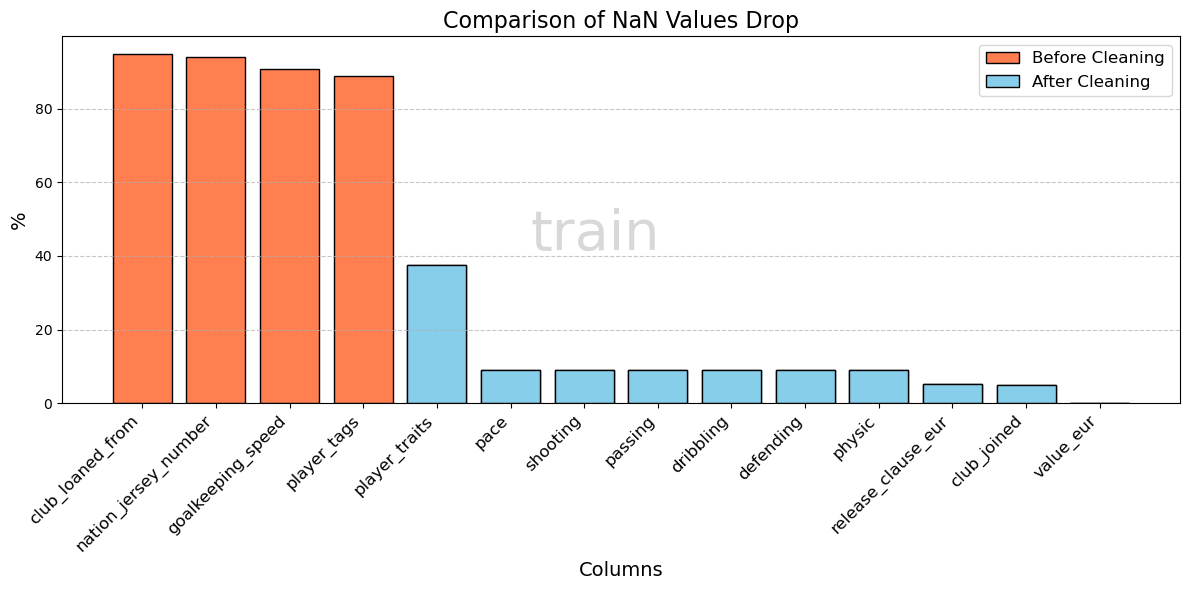

In [21]:
# Load the training data and handle NaN values
train_data = get_data("train")
train_data = preprocess_nan(data=train_data, dataset_type="train")


#### Missing values conclusions:

Four columns that contained the largest number of missing values were: Club Loaned From, Nation Jersey Number, Goalkeeper Speed and Player Tags. Each of these columns contained more than 85% of missing values. It would be a challenge to impute them based on such a small number of present observations. Besides, as per the domain-specific knowledge, these variables don't have a strong correlation with a player's position. As a result, these columns were dropped from the dataset to maintain data quality and avoid potential biases in the analysis.

<a id="2"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Target column analysis</center></h3>

Since we want to undersatand the distribution of the target column, we need to plot it to be able to assess it visually and try to observe trends or inconcistencies.

In [22]:
def plot_dist(data: pd.DataFrame, column: str) -> None:
    """
    Plots distribution of given column

    :param data: dataset
    :param column: target column
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data[column], 
        kde=True,  
        color='coral', 
        bins=30
    )
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


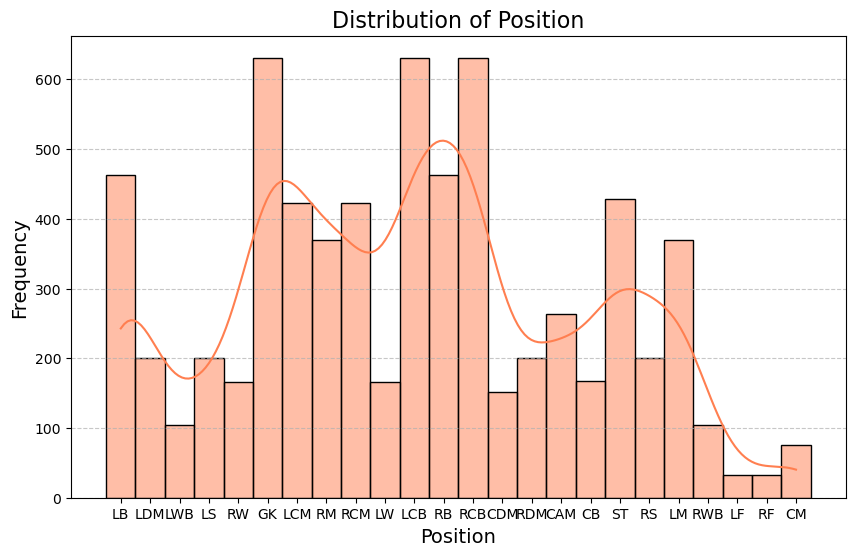

In [23]:
plot_dist(train_data, "position")

#### Traget column conclusions:

As we can see there are more observations for the players on positions RCB, LCB, GK (631 observations each). The least represented positions are LF and RF (34 observations each). This will likely affect the prediction accuracy for the less frequent positions since small samples often result in high variance, low bias (potentially overfitting), and poor generalization to new data. When assessing model performance, we need to take this into account.

To better visualize the placement of each position on the field, let's draw a football pitch and pinpoint all 24 positions on it.

In [24]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if view.lower().startswith("h"):
        fig,ax = plt.subplots(figsize=(20.8, 13.6))
        plt.ylim(98, 210)
        plt.xlim(-2, 138)
    else:
        fig,ax = plt.subplots(figsize=(13.6, 20.8))
        plt.ylim(-2, 210)
        plt.xlim(-2, 138)
    ax.axis('off')

    # side and goal lines
    lx1 = [0, 0, 136, 136, 0]
    ly1 = [0, 208, 208, 0, 0]

    plt.plot(lx1,ly1,color=line,zorder=5)

    # boxes, 6 yard box and goals
    # outer boxes
    lx2 = [27.68, 27.68, 108.32, 108.32] 
    ly2 = [208, 175, 175, 208]
    plt.plot(lx2,ly2,color=line,zorder=5)

    lx3 = [27.68, 27.68, 108.32, 108.32] 
    ly3 = [0, 33, 33, 0]
    plt.plot(lx3,ly3,color=line,zorder=5)

    # goals
    lx4 = [60.68, 60.68, 75.32, 75.32]
    ly4 = [208, 208.4, 208.4, 208]
    plt.plot(lx4,ly4,color=line,zorder=5)

    lx5 = [60.68, 60.68, 75.32, 75.32]
    ly5 = [0, -0.4, -0.4, 0]
    plt.plot(lx5,ly5,color=line,zorder=5)

    # 6 yard boxes
    lx6 = [49.68, 49.68, 86.32, 86.32]
    ly6 = [208, 199, 199, 208]
    plt.plot(lx6,ly6,color=line,zorder=5)

    lx7 = [49.68, 49.68, 86.32, 86.32]
    ly7 = [0, 9, 9, 0]
    plt.plot(lx7,ly7,color=line,zorder=5)

    # Halfway line, penalty spots, and kickoff spot
    lx8 = [0, 136] 
    ly8 = [104, 104]
    plt.plot(lx8,ly8,color=line,zorder=5)

    plt.scatter(68, 186, color=line, zorder=5)
    plt.scatter(68, 22, color=line, zorder=5)
    plt.scatter(68, 104, color=line, zorder=5)

    circle1 = plt.Circle((68, 187), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=1, alpha=1)
    circle2 = plt.Circle((68, 21), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=1, alpha=1)
    circle3 = plt.Circle((68, 104), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=2, alpha=1)

    rec1 = plt.Rectangle((40, 175), 60, 33, ls='-', color=pitch, zorder=1, alpha=1)
    rec2 = plt.Rectangle((40, 0), 60, 33, ls='-', color=pitch, zorder=1, alpha=1)
    rec3 = plt.Rectangle((-1, -1), 140, 212, ls='-', color=pitch, zorder=1, alpha=1)

    ax.add_artist(rec3)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(rec1)
    ax.add_artist(rec2)
    ax.add_artist(circle3)   

In [25]:
# List all positions and their coordinates

x = [
    68, 68, 68, 32, 104, 68, 32, 104, 68, 44, 88, 20, 116, 12, 124, 68, 68, 16, 120, 16, 120, 40, 96, 32, 104, 32, 104
]

y = [
    186, 150, 1, 150, 150, 112, 114, 114, 14, 16, 16, 24, 24, 50, 50, 50, 74, 74, 74, 130, 130, 74, 74, 186, 186, 50, 50
]

n = [
    'ST', 'CF', 'GK', 'LF', 'RF', 'CAM', 'LAM', 'RAM', 'CB', 
    'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB', 'CDM', 'CM', 'LM', 
    'RM', 'LW', 'RW', 'LCM', 'RCM', 'LS', 'RS', 'LDM', 'RDM'
]

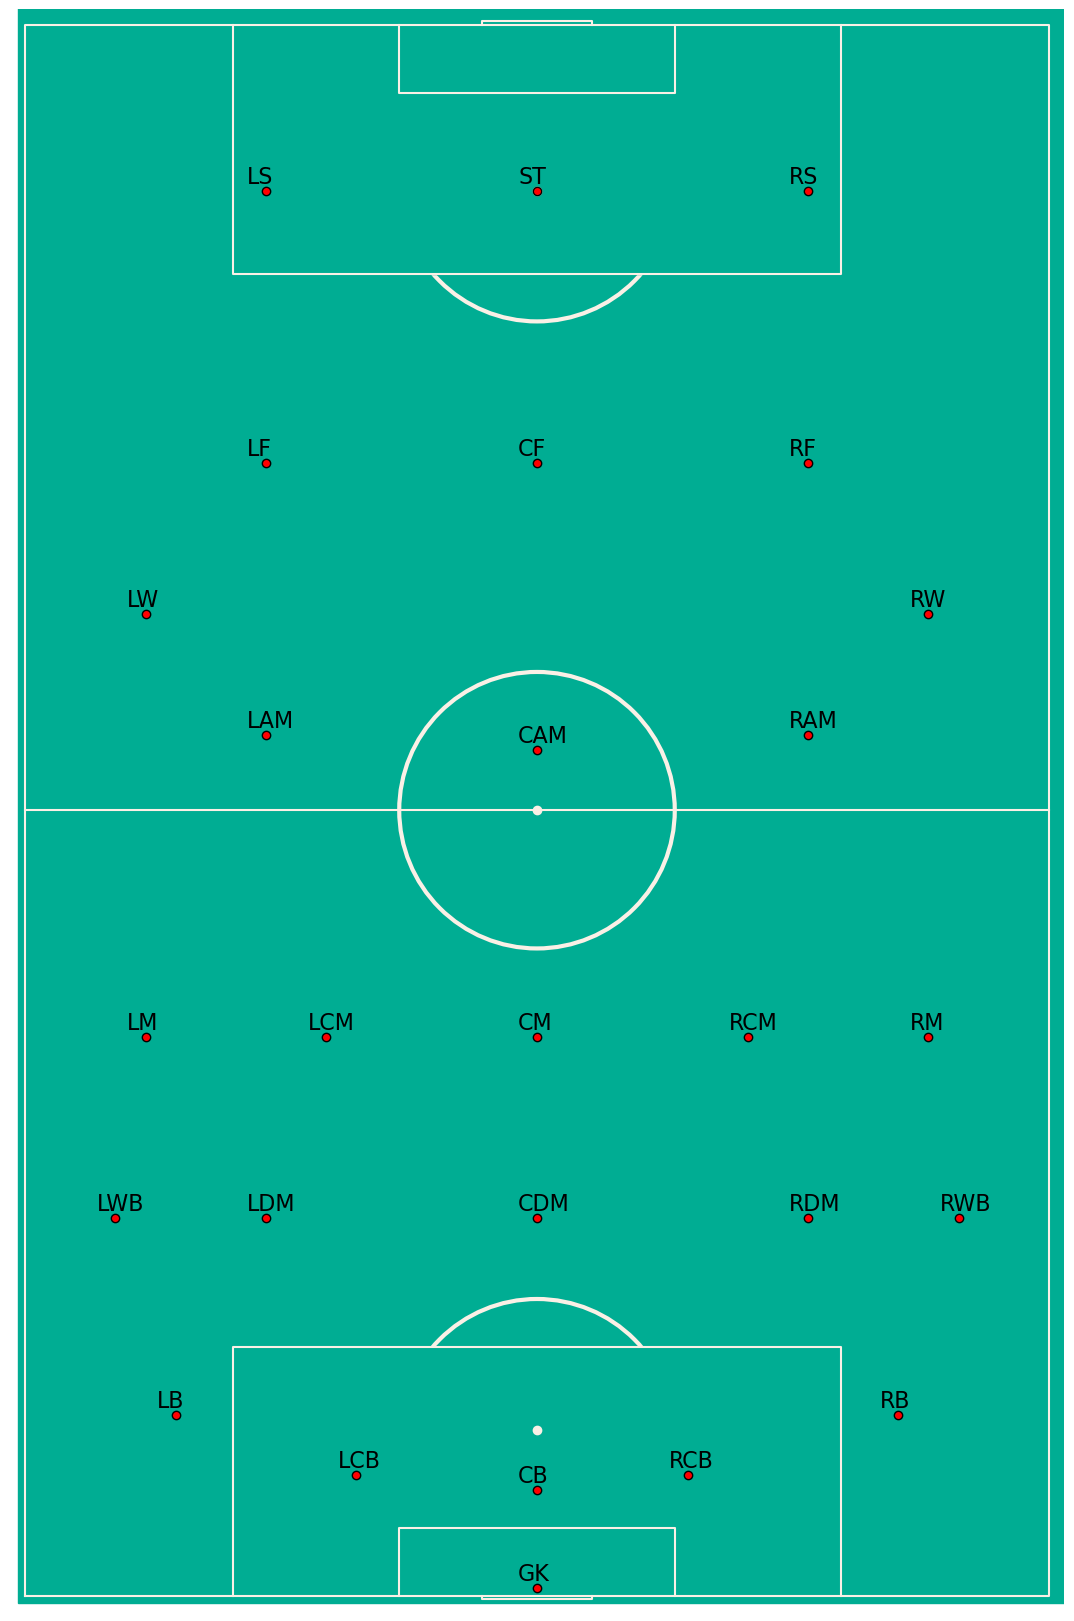

In [26]:
# Draw the pitch with positions
draw_pitch(
    "#00ad93", 
    "#faf0e6", 
    "v", 
    "full"
)

for i, pos in enumerate(n):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )
plt.show()

<a id="3"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Categorical Data Analysis</center></h3>

To undesrtand which features are important, and deduce possible correlation, let's start by analyzing our categorical columns.

In [27]:
for col in train_data.select_dtypes(include=['object', 'category']).columns:
    print(f'Categorical column {col} has {train_data[col].nunique()} unique values')

Categorical column short_name has 6692 unique values
Categorical column birthday_date has 3991 unique values
Categorical column club_name has 701 unique values
Categorical column league_name has 55 unique values
Categorical column club_joined has 1263 unique values
Categorical column nationality_name has 144 unique values
Categorical column preferred_foot has 2 unique values
Categorical column work_rate has 9 unique values
Categorical column body_type has 10 unique values
Categorical column real_face has 2 unique values
Categorical column player_traits has 772 unique values
Categorical column position has 24 unique values


We can see that some of the columns - like short_name or club_joined - have several thousand unique values. Therefore, it wouldn't be helpful for further analysis to ransform them into numerical variables for several reasons.

<strong>Unique Value Considerations</strong>

Columns like short_name and club_joined have high cardinality (thousands of unique values). High cardinality features can be problematic in machine learning models, since they can increase computational complexity, potentially lead to overfitting, rovide minimal predictive value. Direct numerical transformation (like one-hot encoding) would be computationally expensive, create sparse and inefficient feature matrices, and potentially overwhelm other meaningful features.

<strong>Feature Relevance Assessment</strong>

Personal identifiers (name) are typically not predictive of performance or position. Temporal features like club_joined may not directly correlate with on-field position. These features introduce noise rather than meaningful signal in predictive models.

<strong>Conclusion</strong>

We decided to remove high-cardinality categorical columns and focus on features directly related to player position. For Moderate and Low Cardinality Columns, we will consider one of the following techniques:
-One-hot encoding
-Label encoding
-Replacement with equivalent numerical value (like computing a player's age based on birthday_date)

The goal will be to transform these categorical features into a format that provides meaningful insights without overwhelming the model with unnecessary complexity.

Now let's plot the density of our categorical variables to better examine existing patterns.

In [30]:
def plot_categorical_dist(data: pd.DataFrame, n: int = 10) -> None:
    """
    Plots categorical parameters

    :param n: top n of unique values
    """
    categorical_columns = [
        col for col in data.select_dtypes(include=['object', 'category']).columns
    ]

    n_cols = 3
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(categorical_columns):
        top_categories = data[col].value_counts().head(10)

        sns.barplot(
            x=top_categories.index,
            y=top_categories.values,
            hue=top_categories.values,
            ax=axes[i],
            palette="coolwarm"
        )
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(len(categorical_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

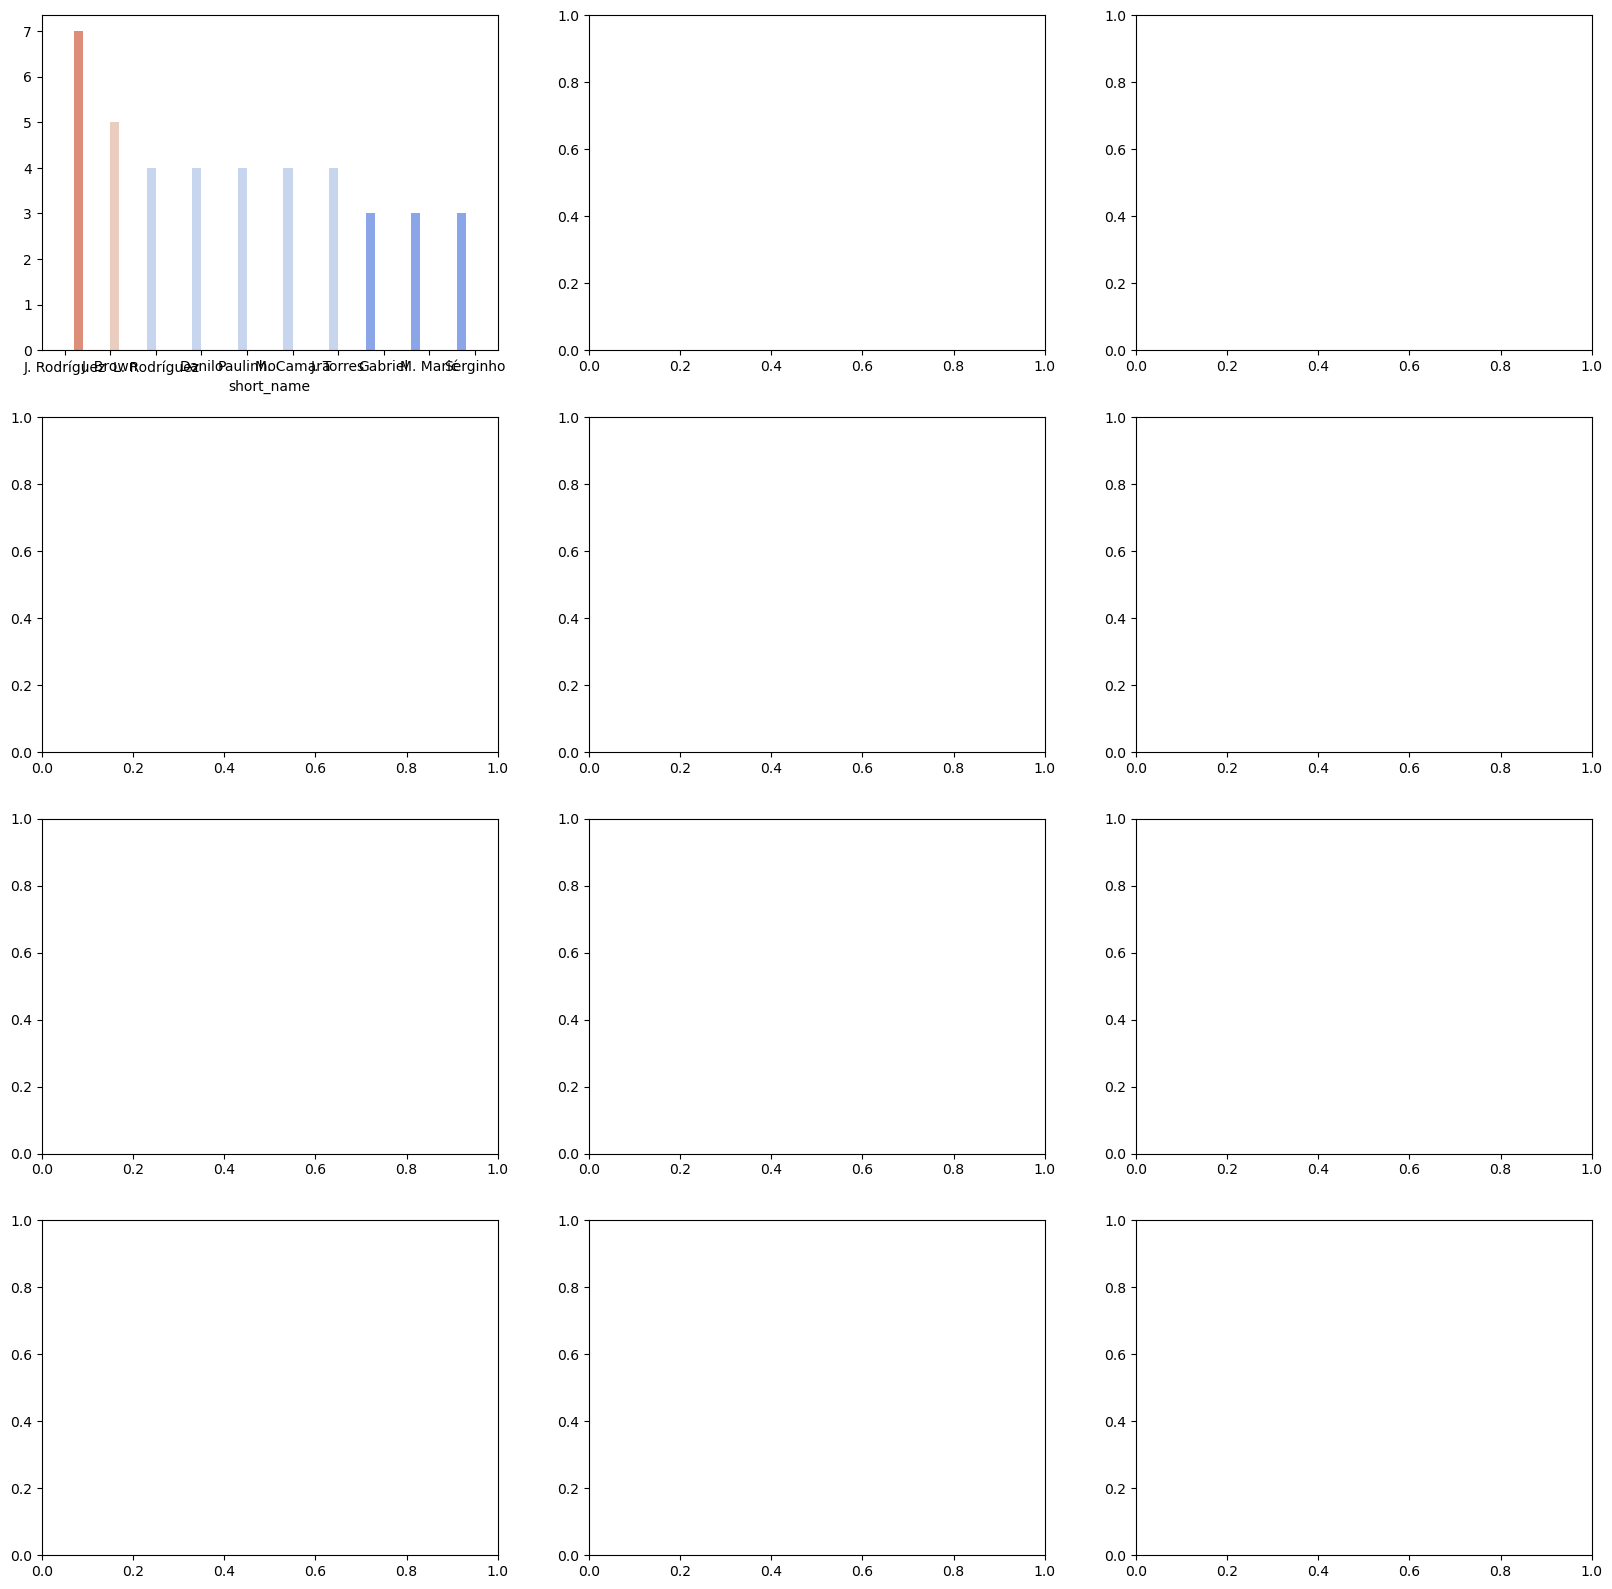

In [31]:
plot_categorical_dist(data=train_data)

Some of the valuable conclusions we can draw from the graphs are that 1) a large number of players possess a Normal body type; 2) "Speed Dribbler" is one of the most frequent characteristics of the player_traits. These observations will come in handy in our further analysis and pipeline design.

<a id="4"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Numerical Data Analysis</center></h3>

Now let's move on to assessing the Numerical columns.

In [32]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

train_data[numeric_columns].describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,6895.000000,6895.000000,6895.000000,6.893000e+03,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,...,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000
mean,223463.552719,68.825671,72.031327,4.320388e+06,12034.126178,181.478898,75.527919,1.361856,16.442350,2022.754605,...,49.883249,61.875997,51.281653,52.249021,49.736766,15.897317,15.690210,15.558666,15.819144,16.003046
std,26876.952793,5.950459,6.070890,1.052554e+07,24630.820430,6.862683,7.041120,0.760018,15.440185,1.204310,...,15.663569,10.937084,19.654312,20.898714,20.613351,17.451010,16.752522,16.316593,17.159677,17.854369
min,41.000000,49.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,...,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,207602.500000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,...,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,227951.000000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,...,50.000000,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,242423.500000,72.000000,76.000000,2.900000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,...,62.000000,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2028.000000,...,93.000000,96.000000,90.000000,93.000000,92.000000,91.000000,92.000000,91.000000,92.000000,90.000000


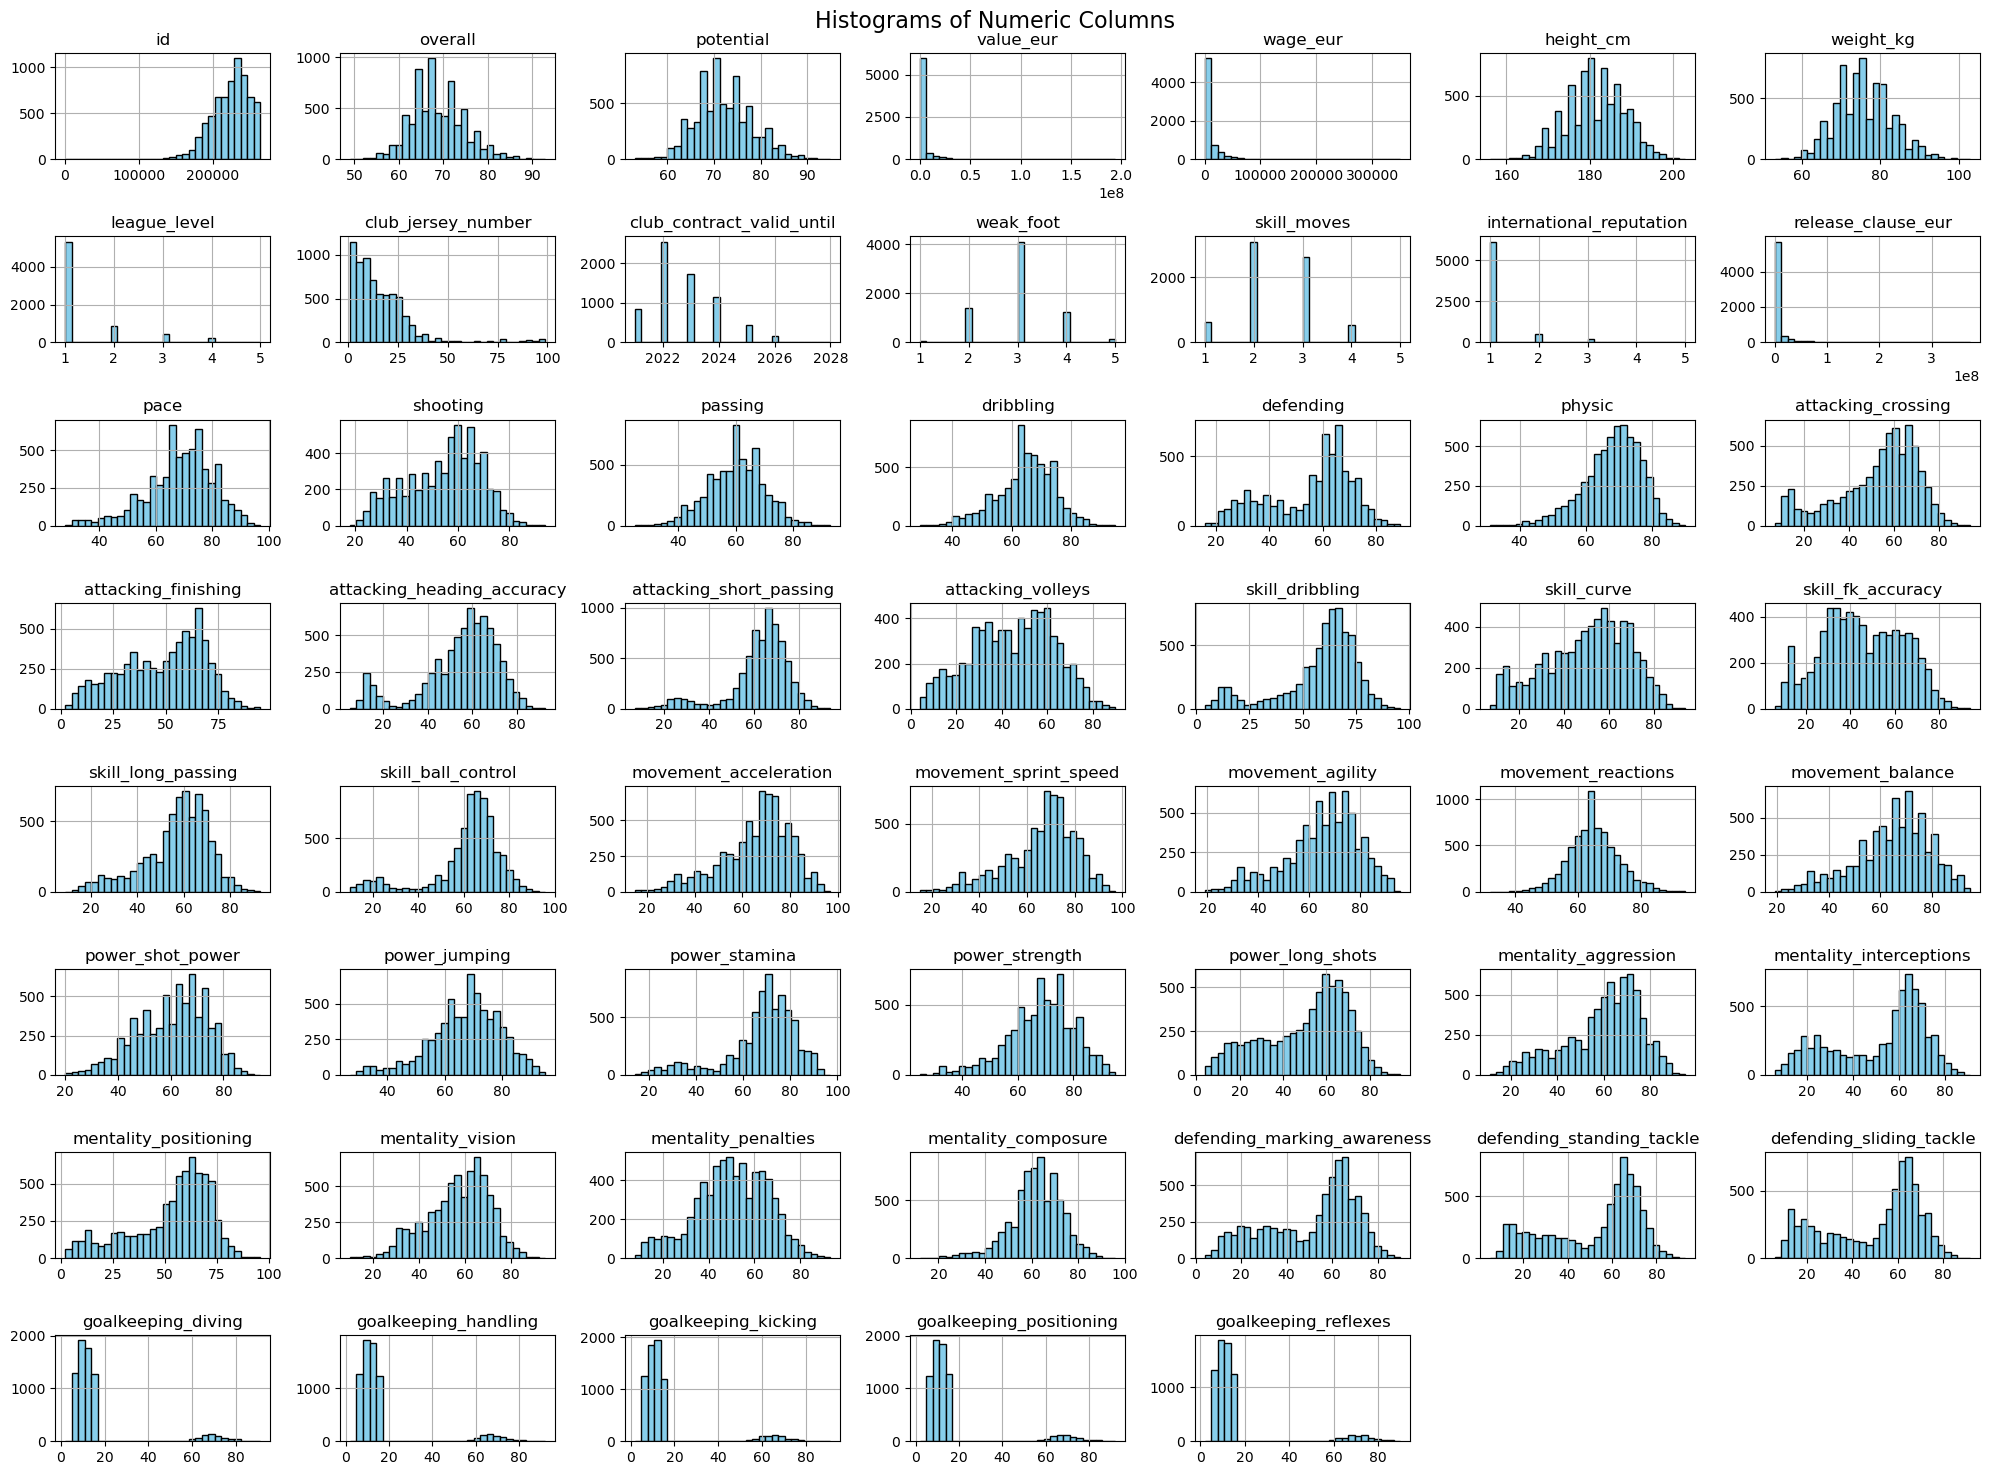

In [33]:
train_data[numeric_columns].hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

The visual analysis tells us the the majority of out numerical columns have a Gaussian bell-shaped distribution, except for the skills relevant for goalkeeper positions.

In [ ]:
correlation_matrix = train_data[numeric_columns].corr()

# Since we have a lot of variables, we need to extract only those with high correaltion
correlation_threshold = 0.9

correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) > correlation_threshold:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_pairs_df = correlated_pairs_df.drop_duplicates()

print("Highly correlated pairs:")
print(correlated_pairs_df)

NameError: name 'train_data' is not defined

In [ ]:

plt.figure(figsize=(20, 16))

# Create a heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    cmap='coolwarm',  # Color palette (blue-red)
    center=0,  # Center color scale at 0
    vmin=-1, 
    vmax=1,
    square=True,  # Make plot square
    linewidths=0.5,  # Add lines between cells
    cbar_kws={"shrink": .8}  # Adjust colorbar size
)

# Customize the plot
plt.title('Correlation Matrix Heatmap', fontsize=16, pad=20)
plt.tight_layout()

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

NameError: name 'correlation_matrix' is not defined

<Figure size 2000x1600 with 0 Axes>

<a id="5"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Missing Values Imputation</center></h3>

In [ ]:
def fill_nan_with_reg(data: pd.DataFrame, column: str, correlation_matrix: pd.DataFrame, corr_threshold: float = 0.8) -> pd.DataFrame:
    """
    Function fills NaN values with regression, regressors of which is highly correlated columns

    :param data: train / test
    :param column: column with NaN
    :param correaltion matrix: correlation matrix where column to be fiiled exists
    :param corr_threshold: value which is gonna be chosen for correalted variables
    """
    inital_nan = data[column].isna().sum()
    if column not in correlation_matrix.columns:
        raise ValueError(f"Column '{column}' not found in correlation matrix.")
    
    features = correlation_matrix[column][abs(correlation_matrix[column]) > corr_threshold].index.tolist()

    correlated_features = [column]
    for feature in features:
        if len(correlated_features) >= 4:
            break
        if data[feature].isna().sum() == 0:
            correlated_features.append(feature)
    
    print(correlated_features)
    
    correlated_features.remove(column)

    if not correlated_features:
        raise ValueError(f"No features with correlation above {corr_threshold} for column '{column}'.")

    print(f"Highly correlated features with '{column}': {correlated_features}")

    data_with_values = data[~data[column].isna()]
    data_with_nan = data[data[column].isna()]
    
    if data_with_values.empty:
        raise ValueError(f"No non-NaN rows found for column '{column}' to train regression model.")
    
    X = data_with_values[correlated_features]
    y = data_with_values[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Filled {inital_nan} with R^2 score of {r2:.4f}')
    
    predicted_values = model.predict(data_with_nan[correlated_features])
    data.loc[data[column].isna(), column] = predicted_values
    
    return data[column]

In [ ]:
def fill_nan_with_mean(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[column] = data[column].fillna(data[column].mean())
    
    return data[column]

In [ ]:
nan_counts = train_data.isna().sum()

columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


value_eur                2
club_joined            351
release_clause_eur     353
player_traits         2589
pace                   631
shooting               631
passing                631
dribbling              631
defending              631
physic                 631
dtype: int64


In [ ]:
numeric_columns = train_data.select_dtypes(include=["float64", "int64"]).columns

for column in numeric_columns:
    if train_data[column].isna().sum() > 0:
        train_data[column] = fill_nan_with_reg(train_data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)

nan_counts = train_data.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

['value_eur', 'wage_eur']
Highly correlated features with 'value_eur': ['wage_eur']
Filled 2 with R^2 score of 0.7338
['release_clause_eur', 'value_eur', 'wage_eur']
Highly correlated features with 'release_clause_eur': ['value_eur', 'wage_eur']
Filled 353 with R^2 score of 0.9926
['pace', 'movement_acceleration', 'movement_sprint_speed']
Highly correlated features with 'pace': ['movement_acceleration', 'movement_sprint_speed']
Filled 631 with R^2 score of 0.9994
['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power']
Highly correlated features with 'shooting': ['attacking_finishing', 'attacking_volleys', 'power_shot_power']
Filled 631 with R^2 score of 0.9884
['passing', 'attacking_crossing', 'attacking_short_passing', 'skill_curve']
Highly correlated features with 'passing': ['attacking_crossing', 'attacking_short_passing', 'skill_curve']
Filled 631 with R^2 score of 0.9612
['dribbling', 'passing', 'skill_dribbling', 'skill_ball_control']
Highly correlated featur

<a id="6"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Outlier Processing</center></h3>

In [ ]:
def remove_outliers(df, method='zscore', threshold=3):
    df_cleaned = df.copy()
    numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

    if method == 'zscore':
        for col in numeric_columns:
            mean = df_cleaned[col].mean()
            std = df_cleaned[col].std()
            z_scores = (df_cleaned[col] - mean) / std
            df_cleaned = df_cleaned[np.abs(z_scores) <= threshold]
    
    elif method == 'iqr':
        for col in numeric_columns:
            q1 = df_cleaned[col].quantile(0.25)
            q3 = df_cleaned[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    else:
        raise ValueError("Method must be either 'zscore' or 'iqr'")
    
    return df_cleaned

In [ ]:
before_preprocessing_length = len(train_data)

train_data = remove_outliers(train_data, "zscore", 4)

print(f'Changed from {before_preprocessing_length} to {len(train_data)}')

Changed from 6895 to 6332


<a id="7"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Feature Engineering</center></h3>

In [ ]:
def put_primary_priority_skill(data: pd.DataFrame, skill_pool: list[str]) -> pd.DataFrame:
    data["priority_skill"] = data[skill_pool].idxmax(axis=1)
    
    return data

In [ ]:
def calculate_position_priority_skill(data: pd.DataFrame) -> pd.DataFrame:
    prefixes = {
        'attacking': [col for col in data.columns if col.startswith('attacking')],
        'defending': [col for col in data.columns if col.startswith('defending')],
        'goalkeeping': [col for col in data.columns if col.startswith('goalkeeping')]
    }
    
    for prefix, cols in prefixes.items():
        data[f'{prefix}_avg'] = data[cols].mean(axis=1)
    
    avg_columns = [f'{prefix}_avg' for prefix in prefixes.keys()]
    data['position_priority_skill'] = data[avg_columns].idxmax(axis=1).str.replace('_avg', '', regex=False)
    
    data.drop(columns=avg_columns, inplace=True)
    
    return data

In [ ]:
def put_secondary_priority_skill(data: pd.DataFrame) -> pd.DataFrame:
    groups = {
        'movement': [col for col in data.columns if col.startswith('movement')],
        'power': [col for col in data.columns if col.startswith('power')],
        'mentality': [col for col in data.columns if col.startswith('mentality')]
    }
    
    for group_name, columns in groups.items():
        data[f'{group_name}_priority_skill'] = data[columns].idxmax(axis=1)
    
    return data

In [ ]:
from collections import Counter

train_data = get_data("train")
# count = train_data["player_traits"].str.contains("Shot", case=False, na=False).sum()

# train_data["player_traits"].unique()
# count

# train_data.columns

print(train_data.shape)

columns = [
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending"
]

train_data = put_primary_priority_skill(train_data, columns)

train_data = put_secondary_priority_skill(train_data)

train_data["movement_priority_skill"]

(6895, 70)


/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_18060/1812914685.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


0            movement_agility
1            movement_balance
2       movement_acceleration
3          movement_reactions
4       movement_sprint_speed
                ...          
6890    movement_acceleration
6891         movement_balance
6892    movement_acceleration
6893         movement_agility
6894       movement_reactions
Name: movement_priority_skill, Length: 6895, dtype: object

In [ ]:
def one_hot_trait_encode(data: pd.DataFrame, useful_traits: list[str]) -> pd.DataFrame:
    for trait in useful_traits:
        data[trait] = data['player_traits'].str.contains(trait, case=False, na=False).astype(int)
        
    return data

In [ ]:
def delete_high_corr(data: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    import numpy as np

    numeric_cols = data.select_dtypes(include=[np.number]).columns

    corr_matrix = data[numeric_cols].corr().abs()

    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Deleted {len(to_drop)} columns with corr > {threshold}:")
    for col in to_drop:
        print(f"- {col}")

    data_reduced = data.drop(columns=to_drop)

    return data_reduced

In [ ]:
def tranform_age(data: pd.DataFrame, input_column: str, output: str, age_type: str) -> pd.DataFrame:
    data[input_column] = pd.to_datetime(data[input_column])

    data[output] = pd.Timestamp.now().year - data[input_column].dt.year

    data.drop(columns=[input_column], inplace=True)

    return data

In [ ]:
def split_height_and_type(column):
    height = column.str.extract(r'\((\d+[-\+]\d*)\)')[0]
    body_type = column.str.extract(r'^(\w+)')[0]
    return height, body_type

In [ ]:
def preprocess_features(data: pd.DataFrame) -> pd.DataFrame:
    data = tranform_age(data=data, input_column="birthday_date", output="age", age_type="birthday")

    data = tranform_age(data=data, input_column="club_joined", output="club_age", age_type="club")

    _, data["body_type_cleaned"] = split_height_and_type(data["body_type"])

    return data

In [ ]:
print(train_data.isnull().sum())

train_data = preprocess_features(train_data.copy())

print(train_data.isnull().sum())

train_data["club_age"]

id                            0
short_name                    0
overall                       0
potential                     0
value_eur                     2
                           ... 
position                      0
priority_skill              631
movement_priority_skill       0
power_priority_skill          0
mentality_priority_skill      0
Length: 74, dtype: int64
id                            0
short_name                    0
overall                       0
potential                     0
value_eur                     2
                           ... 
power_priority_skill          0
mentality_priority_skill      0
age                           0
club_age                    351
body_type_cleaned             0
Length: 75, dtype: int64


0       3.0
1       3.0
2       3.0
3       6.0
4       5.0
       ... 
6890    3.0
6891    3.0
6892    4.0
6893    9.0
6894    3.0
Name: club_age, Length: 6895, dtype: float64

<a id="8"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Categorical Encoding</center></h3>

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encode(column: pd.Series):
    le = LabelEncoder()

    return le.fit_transform(column)

In [ ]:
def transform_cat_to_num(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    le = LabelEncoder()
    for column in columns:
        if column in data.columns and column != "position":
            print(f'Tranforming {column} ({len(data[column].unique())} unique values) to label columns')
            data[column] = le.fit_transform(data[column])

    return data

<a id="9"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Dropping Unnecessary Columns</center></h3>

In [ ]:
train_data = train_data.drop(columns=["player_traits", "nationality_name", "club_name", "short_name", "league_name", "id"])

In [ ]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

train_data = transform_cat_to_num(train_data, categorical_columns)

Tranforming club_loaned_from (197 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_tags (62 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns


In [ ]:
train_data.head()

,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_loaned_from,club_contract_valid_until,...,goalkeeping_reflexes,goalkeeping_speed,position,priority_skill,movement_priority_skill,power_priority_skill,mentality_priority_skill,age,club_age,body_type_cleaned
0,71,71,1400000.0,10000,176,73,1,29,196,2026,...,12,NaN,LB,2,1,3,2,35,3.0,1
1,65,71,1000000.0,2000,183,73,1,4,196,2022,...,11,NaN,LDM,2,2,3,0,28,3.0,0
2,65,77,1600000.0,2000,178,69,1,19,196,2026,...,11,NaN,LWB,2,0,3,0,23,3.0,1
3,72,72,2300000.0,5000,188,81,1,9,196,2023,...,9,NaN,LS,4,3,4,4,32,6.0,0
4,65,65,525000.0,3000,179,74,1,30,196,2022,...,15,NaN,LB,2,4,0,2,34,5.0,1


<a id="10"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Building Pipeline Function</center></h3>

In [ ]:
def preprocess_data(data: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    # Drop those columns that have to many nan values
    data = preprocess_nan(data=data, dataset_type=dataset_type, plot=False)
    
    # Remove outliers
    # data = remove_outliers(data, "zscore", 4)

    # Generate Features
    data = preprocess_features(data)

    columns_to_analyze = [
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending"
    ]
    
    data = put_primary_priority_skill(data, columns_to_analyze)

    data = put_secondary_priority_skill(data)

    data = one_hot_trait_encode(data, ["Team Player", "Power Header", "Long Shot", "Pass", "Cross", "Tackle", "Technical", "Shot", "Speed", "Dribbler"])

    data = transform_cat_to_num(data, data.select_dtypes(include=['object']).columns)

    data = data.drop(
        columns=[
            "player_traits", 
            "nationality_name", 
            "club_name", 
            "short_name", 
            "league_name", 
            "club_contract_valid_until",
            "club_jersey_number",
            "id",
            "real_face",
            "club_age",
        ]
    )
    
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    # Fill nan values
    for column in numeric_columns:
        if data[column].isna().sum() > 0:
            try:
                data[column] = fill_nan_with_mean(data.copy(), column)
                # data[column] = fill_nan_with_reg(data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)
            except Exception as e:
                print(e)

    data = delete_high_corr(data, 0.9)

    return data
    

In [ ]:
train_data = get_data("train")

initial_columns = train_data.columns

In [ ]:
train_data = preprocess_data(train_data, "train")

deleted_columns = []
for column in initial_columns:
    if column not in train_data.columns:
        deleted_columns.append(column)

print(f'Deleted columns: {deleted_columns}')
train_data.shape

Tranforming short_name (6692 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (773 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_posit

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_18060/1812914685.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


(6895, 59)

In [ ]:
train_data.shape

(6895, 59)

<a id="11"></a>
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:darkblue; border:0; color:white' role="tab" aria-controls="home"><center>Building Model / Testing</center></h3>

In [ ]:
X = train_data.drop("position", axis=1)
y = train_data["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=16, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")

print(f1) 

rf.feature_importances_

0.4005197524573193


array([0.01282115, 0.01436741, 0.01658315, 0.01445926, 0.0202496 ,
       0.01830421, 0.00410577, 0.03325384, 0.00613829, 0.01961196,
       0.00156105, 0.00990236, 0.00868093, 0.02379896, 0.02672542,
       0.01818095, 0.01922755, 0.03765367, 0.01763523, 0.03648299,
       0.03275249, 0.03894229, 0.02496042, 0.02355338, 0.03165008,
       0.02284177, 0.02518591, 0.02398237, 0.02356834, 0.02005404,
       0.01505073, 0.0199876 , 0.01733587, 0.01910845, 0.02519316,
       0.02360973, 0.02464705, 0.01913852, 0.03444256, 0.02246802,
       0.02166437, 0.01623422, 0.0298586 , 0.01521624, 0.02608043,
       0.00799799, 0.00765335, 0.0089535 , 0.00123944, 0.0010227 ,
       0.00188689, 0.00147638, 0.00179341, 0.00136494, 0.00171949,
       0.00213591, 0.00240098, 0.00308462])

In [ ]:
test_data = get_data("test")

ids = test_data["id"]

test_data = preprocess_data(test_data, "test")

rf.fit(X_train, y_train)

predictions = rf.predict(test_data)
output_df = pd.DataFrame({'id': ids, 'position': predictions})
output_df.to_csv('submission.csv', index=False)

Tranforming short_name (764 unique values) to label columns
Tranforming club_name (488 unique values) to label columns
Tranforming league_name (52 unique values) to label columns
Tranforming nationality_name (82 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (194 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_positio

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_18060/1812914685.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


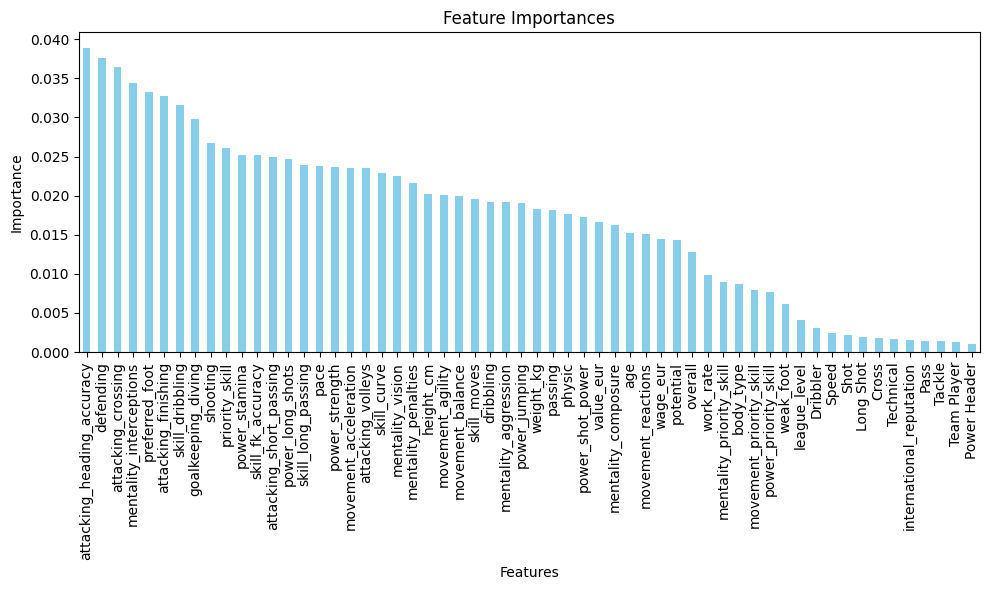

In [ ]:
feature_importances = rf.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
train_data.isnull().sum()

overall                       0
potential                     0
value_eur                     0
wage_eur                      0
height_cm                     0
weight_kg                     0
league_level                  0
preferred_foot                0
weak_foot                     0
skill_moves                   0
international_reputation      0
work_rate                     0
body_type                     0
pace                          0
shooting                      0
passing                       0
dribbling                     0
defending                     0
physic                        0
attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
attacking_short_passing       0
attacking_volleys             0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_long_passing            0
movement_acceleration         0
movement_agility              0
movement_reactions            0
movement

In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid

param_grid = {
    'n_estimators': [i for i in range(100,300,100)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(8,20,2)]
}

grid = ParameterGrid(param_grid)
results = []

for params in grid:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((params, f1))

results = sorted(results, key=lambda x: x[1], reverse=True)

print("Best configurations by F1 Score:")
for res in results[:5]:
    print(res)

params_list = [str(res[0]) for res in results]
f1_scores = [res[1] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores)), f1_scores, marker='o')
plt.xticks(range(len(params_list)), params_list, rotation=90)
plt.xlabel('Model Configuration')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Model Configurations')
plt.tight_layout()
plt.show()

# P.S. Insight about GK (Arguably)

In [ ]:
def calculate_goalkeeping_avg_by_position(data: pd.DataFrame) -> pd.DataFrame:
    goalkeeping_columns = [col for col in data.columns if col.startswith('goalkeeping')]
    
    grouped_data = data.groupby('position')[goalkeeping_columns].mean()
    
    return grouped_data


In [ ]:
train_data = get_data("train")
positions = calculate_goalkeeping_avg_by_position(train_data)
positions

,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
position,,,,,,
CAM,10.482890,10.224335,10.520913,10.296578,10.623574,NaN
CB,10.904192,10.718563,10.694611,10.832335,10.592814,NaN
CDM,10.317881,10.364238,10.496689,10.715232,10.463576,NaN
CM,10.653333,10.693333,10.573333,10.600000,10.466667,NaN
GK,69.744849,67.326466,65.716323,68.695721,71.107765,40.220285
LB,10.507559,10.369330,10.455724,10.466523,10.598272,NaN
LCB,10.627575,10.416799,10.532488,10.678288,10.318542,NaN
LCM,10.425532,10.732861,10.304965,10.565012,10.286052,NaN
LDM,10.388060,10.651741,10.462687,10.343284,10.830846,NaN


In [ ]:
train_data = get_data("train")

train_data_non_gk = train_data[train_data['goalkeeping_speed'].isna()]

train_data_non_gk = preprocess_data(train_data_non_gk, "train")

X = train_data_non_gk.drop("position", axis=1)
y = train_data_non_gk["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=16, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")

print(f1) 

Tranforming short_name (6090 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (695 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (5 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 12 columns with corr > 0.9:
- release_clause_eur
- attacking_finishing
- skill_dribbling
- skill_ball_control
-

In [ ]:
test_data = get_data("test")

ids = test_data["id"]

gk_mask = test_data["goalkeeping_speed"] > 40
gk_ids = test_data[gk_mask]["id"]

gk_predictions = pd.DataFrame({'id': gk_ids, 'position': 'GK'})

non_gk_data = test_data[~gk_mask]

non_gk_ids = non_gk_data["id"]

non_gk_data = preprocess_data(non_gk_data, "test")

missing_columns = X_train.columns.difference(non_gk_data.columns)
for col in missing_columns:
    non_gk_data[col] = 0 

non_gk_data = non_gk_data[X_train.columns]

predictions_non_gk = rf.predict(non_gk_data)

non_gk_predictions = pd.DataFrame({'id': non_gk_ids, 'position': predictions_non_gk})

output_df = pd.concat([gk_predictions, non_gk_predictions])

output_df = output_df.sort_values(by='id')

output_df.to_csv('submission.csv', index=False)

print("Predictions are saved to submission.csv file")


Tranforming short_name (722 unique values) to label columns
Tranforming club_name (467 unique values) to label columns
Tranforming league_name (52 unique values) to label columns
Tranforming nationality_name (82 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming body_type (10 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (179 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Tranforming priority_skill (6 unique values) to label columns
Tranforming movement_priority_skill (5 unique values) to label columns
Tranforming power_priority_skill (5 unique values) to label columns
Tranforming mentality_priority_skill (6 unique values) to label columns
Deleted 9 columns with corr > 0.9:
- release_clause_eur
- defending_marking_awareness
- defending_standing_tackle
- defen

/var/folders/_k/4jmlcdh94fn8f_g2j15scs2m0000gn/T/ipykernel_18060/1812914685.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data["priority_skill"] = data[skill_pool].idxmax(axis=1)


### Key Insights and recommendations:

#### 1. Exploratory Data Analysis and Feature Engineering:
1) Leveraged domain-informed feature engineering by decomposing latent player attributes through priority skills and position-specific skill aggregations, revealing nuanced multivariate relationships between player characteristics and positional archetypes.
2) Addressed class imbalance through strategic metric selection (weighted F1-score), mitigating potential bias in predictive modeling and enhancing distributional representativeness.
3) Employed feature correlation analysis and multicollinearity diagnostics to identify orthogonal predictive signals and minimize redundant information propagation.

#### 2. Predictive Modeling Approach:
1) Implemented ensemble learning via Random Forest, utilizing bootstrapped aggregation and feature randomization to capture non-linear interactions and reduce variance.
2) Conducted hyperparameter optimization through cross-validated grid search, systematically exploring the model's hyperparameter landscape to minimize generalization error.
3) Utilized feature importance metrics to establish causal narrative and interpretability, identifying primary drivers of positional classification.

#### 3. Methodological Strengths:
1) Developed a robust, modularized preprocessing architecture with principled strategies for:
- Missing data imputation
- Outlier detection and treatment
- Feature transformation and engineering
2) Applied domain expertise to generate informative, contextually relevant predictive features
3) Maintained a holistic approach to model development, balancing predictive performance with interpretability

#### 4. Potential Model Enhancement Strategies:
1) Explore advanced gradient boosting architectures (XGBoost, LightGBM) to capture more complex feature interactions and potential non-linear decision boundaries.
2) Implement advanced feature engineering techniques:
- High-cardinality feature embedding
- Dimensionality reduction via techniques like PCA or t-SNE
3) Investigate sophisticated imputation methodologies:
- Iterative imputation to leverage latent feature correlations
- Multiple imputation to account for uncertainty in missing data
4) Conduct granular performance diagnostics:
- Per-class performance analysis
- Error surface investigation
- Confusion matrix decomposition to identify systemic misclassification patterns

#### 5. Recommendation Framework:
1) Adopt an iterative, hypothesis-driven modeling approach
2) Continuously validate assumptions through cross-validation and out-of-sample testing
3) Maintain a balance between model complexity and interpretability